In [ ]:
# !pip install -qq pycocotools
# !pip install -qq opencv-python
# !pip install -qq Pillow
# !pip install -qq numpy
# !pip install -qq matplotlib
# !pip install -qq scikit-image
# !pip install -qq moviepy
# !pip install -qq tqdm

In [2]:
import os
from pathlib import Path
import json
import re
import shutil
from typing import List, Tuple, Union

import cv2
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

from skimage import io

from moviepy.editor import VideoFileClip

from tqdm import tqdm

%matplotlib inline

In [4]:
# function to search all the json files in the directory and subdirectories
def search_json_files(directory: str):
    """
    Get all the JSON files present in the folder by looking into the `directory` and
    all the sub-folders recusively.

    NOTE: Should only have JSONs which are required, if there are extra JSONs it considers those too.
    """
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Taking json files from folders of "AnnotationComplete"
            if (file.endswith(".json")) and ("AnnotationComplete" in root):
                json_files.append(os.path.join(root, file))
    return json_files

json_paths = search_json_files('./')
json_paths


['./Patient3_RLL_AnnotationComplete/RLL_PA_FG_frames530-559/instances_default.json',
 './Patient3_RLL_AnnotationComplete/RLL_PA_FG_frames360-529 & 600-660/instances_default.json',
 './Patient4_RLL_AnnotationComplete/patient4_RLL_221-370/instances_default.json',
 './Patient4_RLL_AnnotationComplete/patient4_JD_RLL_frames70-220/instances_default.json',
 './Patient11_RLL_AnnotationComplete/Patient_11_RLL_PA_0050-0350/Patient_11_RLL_PA_0050-0350.json',
 './Patient7_RLL_AnnotationComplete/Patient_07_RLL_PA_0000-0300/Patient_07_RLL_PA_0000-0300.json',
 './Patient20_RLL_AnnotationComplete/Patient_20_RLL_PA_0000-0300/Patient_20_RLL_PA_0000-0300.json',
 './Patient1_RLL_AnnotationComplete/(Patient 1_RLL) tc-padissection-rll-frames1401-1650_1900-2400/instances_default.json',
 './Patient1_RLL_AnnotationComplete/(Patient 1_RLL) tc-padissection-rll-frames1651-1900/instances_default.json',
 './Patient6_RLL_AnnotationComplete/Patient_6_RLL_PA_1450-1750/Patient_6_RLL_PA_1450-1750.json',
 './Patient10_RL

In [5]:
def extract_frame_numbers(path):
    path = Path(path).parent.name
    pattern = r"\d+-\d+"
    matches = re.findall(pattern, path)

    return [tuple(map(int, match.split('-'))) for match in matches]

In [6]:
# test
print(extract_frame_numbers(json_paths[3]))
print(extract_frame_numbers(json_paths[7]))

[(70, 220)]
[(1401, 1650), (1900, 2400)]


In [7]:
# create a Path object for each json file
json_paths = [Path(path) for path in json_paths]
# Path of data in grandparent of each json file
data_paths = [path.parent.parent / 'data' for path in json_paths]

In [8]:
data_paths

[PosixPath('Patient3_RLL_AnnotationComplete/data'),
 PosixPath('Patient3_RLL_AnnotationComplete/data'),
 PosixPath('Patient4_RLL_AnnotationComplete/data'),
 PosixPath('Patient4_RLL_AnnotationComplete/data'),
 PosixPath('Patient11_RLL_AnnotationComplete/data'),
 PosixPath('Patient7_RLL_AnnotationComplete/data'),
 PosixPath('Patient20_RLL_AnnotationComplete/data'),
 PosixPath('Patient1_RLL_AnnotationComplete/data'),
 PosixPath('Patient1_RLL_AnnotationComplete/data'),
 PosixPath('Patient6_RLL_AnnotationComplete/data'),
 PosixPath('Patient10_RLL_AnnotationComplete/data'),
 PosixPath('Patient5_RLL_AnnotationComplete/data'),
 PosixPath('Patient13_RLL_AnnotationComplete/data'),
 PosixPath('Patient2_RLL_AnnotationComplete/data'),
 PosixPath('Patient14_RLL_AnnotationComplete/data')]

In [8]:
def images_data(json_data: dict,
                global_img_idx: int,
                pat_num: str,
                CROP: Tuple,
                frame_set: set):
    """
    In the JSON file, get the images_data from all the `json_data[images']`
    where the frame number is mentioned in the JSON file name.

    Note: This is because some annotations are done for test purposes, so when exporting
    those annotaions are present in `json_data['annotations']`, but should NOT be considered.
    Hence, the old logic, which loops through the annotations present is discarded.
    """
    images_data = []
    oldId_newId = {}
    TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y = CROP

    annotated_images = {ann['image_id'] for ann in json_data['annotations']}
    for i in json_data['images']:
        # If Frame number not present in JSON file name range
        if int(re.findall("\d+", i['file_name'])[0]) not in frame_set:
            continue
        # The Frame is in the range but not annotated
        if i["id"] not in annotated_images:
            continue
        img_data = i.copy()
        oldId_newId[img_data['id']] = global_img_idx
        img_data['id'] = global_img_idx
        global_img_idx += 1
        img_data['height'] = BOTTOMR_Y - TOPL_Y
        img_data['width'] = BOTTOMR_X - TOPL_X
        img_data['file_name'] = pat_num + '/' + img_data['file_name']
        images_data.append(img_data)

    ## Old Logic: Where Images data is taken for which annotation is present
    # for i in json_data['images']:
    #     for j in json_data['annotations']:
    #         if i['id'] == j['image_id']:
    #             img_data = i.copy()
    #             oldId_newId[img_data['id']] = global_img_idx
    #             img_data['id'] = global_img_idx
    #             global_img_idx += 1
    #             img_data['height'] = BOTTOMR_Y - TOPL_Y
    #             img_data['width'] = BOTTOMR_X - TOPL_X
    #             img_data['file_name'] = pat_num + '/' + img_data['file_name']
    #             images_data.append(img_data)
    #             break

    return images_data, oldId_newId, global_img_idx

In [9]:
def annotation_data(json_data: dict,
                    oldId_newId: dict,
                    global_ann_idx: int,
                    CROP: Tuple):
    """
    For all the annotations present, since the image_ids are changed,
    change the image_id in each annotation and also crop the annotation.
    """
    ann_data = []
    TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y = CROP
    for ann in json_data['annotations']:
        # The annotations is present but is for a frame
        # not in the range of JSON file name.
        if ann['image_id'] not in oldId_newId:
            continue
        ann_copy = ann.copy()
        ann_copy['id'] = global_ann_idx
        ann_copy['image_id'] = oldId_newId[ann_copy['image_id']]
        ann_copy['category_id'] = 1 # Single Category
        ann_data.append(ann_copy)
        global_ann_idx += 1

        # Cropping the Segmentation and BBox
        segmentation_list = []
        for seg_id, segment_value in enumerate(ann_copy['segmentation'][0]):
            if seg_id % 2 == 0: # X coordinate
                segmentation_list.append(segment_value - TOPL_X)
            else: # Y coordinate
                segmentation_list.append(segment_value - TOPL_Y)

        ann_copy['segmentation'] = [segmentation_list]
        ann_copy['bbox'][0] -= TOPL_X 
        ann_copy['bbox'][1] -= TOPL_Y
    
    return ann_data, global_ann_idx

In [10]:
def get_cropping_co_ord(image: NDArray):
    """
    Crop the Image
    Loop through each direction, left, right, top and bottom

    When ever the pixel value is greater than [5,5,5], use that pixel as starting
    point for the crop in that direction.
    """
    h, w, _ = image.shape
    # Getting TOPL_X
    for i in range(w):
        if not np.any(image[h//2,i,:] < (5,5,5)):
            TOPL_X = i
            break
        
    # Getting TOPL_Y
    for i in range(h):
        if not np.any(image[i,w//2,:] < (5,5,5)):
            TOPL_Y = i
            break
    
    # Getting BOTTOMR_X
    for i in range(w-1,0,-1):
        if not np.any(image[h//2,i,:] < (5,5,5)):
            BOTTOMR_X = i
            break
    
    # Getting BOTTOMR_Y
    for i in range(h-1,0,-1):
        if not np.any(image[i,w//2,:] < (5,5,5)):
            BOTTOMR_Y = i
            break

    return TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y

### Train - Test Split

In [11]:
import random

def split_images(all_images):
    train_images = []
    train_set = set()
    test_images = []
    test_set = set()

    for img_data in all_images:
        if random.randint(1,10) > 2: # 80-20 split
            train_images.append(img_data)
            train_set.add(img_data['id'])
        else:
            test_images.append(img_data)
            test_set.add(img_data['id'])

    # print(len(train_images), len(test_images), len(train_images)+len(test_images), len(train_set), len(test_set))
    return train_images, test_images, train_set, test_set

def split_ann(all_annotations, train_set):
    train_ann = []
    test_ann = []

    for img_ann in all_annotations:
        if img_ann['image_id'] in train_set:
            train_ann.append(img_ann)
        else:
            test_ann.append(img_ann)

    # print(len(train_ann), len(test_ann), len(train_ann)+len(test_ann))
    return train_ann, test_ann

In [50]:
COMBINATIONS = (('p1','p2'),('p3','p4'),('p5','p6'),
                ('p7','p10'),('p11','p13'), ('p14', 'p20'))

def create_img_and_ann(json_data, data_path, patient_prefix, img_id, ann_id):
         
    # get all files in data_path
    files = os.listdir(data_path)
    # Get a random image file
    img_file = files[0]
    # Read the image
    img = cv2.imread(str(data_path / img_file))
    # Get Cropping Co-ordinates
    TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y = get_cropping_co_ord(img)
    CROP = (TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y)
    
    img_data, oldId_newId, img_id = images_data(json_data, img_id, patient_prefix, CROP, frame_set)
    ann_data, ann_id = annotation_data(json_data, oldId_newId, ann_id, CROP)

    return img_data, ann_data, img_id, ann_id, CROP
    

def copy_images(img_data, data_path, dest_folder, CROP):
    # Copying Images to Common Folder
    dest_path = './allvideo_frames'
    os.makedirs(dest_path+'/'+dest_folder, exist_ok=True)
    TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y = CROP
    for img in tqdm(img_data):
        regex = re.compile(r'frame_.*')
        frame_num = regex.findall(img['file_name'])[0]
        cropped_img = cv2.imread(f"{data_path}/{frame_num}")[TOPL_Y:BOTTOMR_Y, TOPL_X:BOTTOMR_X]
        cv2.imwrite(f"{dest_path}/{img['file_name']}", cropped_img)

def gen_img_ann(json_data, data_path, patient_prefix,
                img_id, ann_id, images_list, ann_list,
                copy = False):
    img_data, ann_data, img_id, ann_id, CROP = \
                                    create_img_and_ann(json_data, data_path, patient_prefix, img_id, ann_id)
    if copy:
        copy_images(img_data, data_path, patient_prefix, CROP)
    images_list.extend(img_data)
    ann_list.extend(ann_data)
    return img_id, ann_id, images_list, ann_list

for pGen1, pGen2 in tqdm(COMBINATIONS):

    img_id = 1
    ann_id = 1
    all_images = []
    all_annotations = []

    pGen1_img_id = 1
    pGen1_ann_id = 1
    pGen1_images = []
    pGen1_annotations = []

    pGen2_img_id = 1
    pGen2_ann_id = 1
    pGen2_images = []
    pGen2_annotations = []
    
    for json_path, data_path in zip(json_paths, data_paths):
        # regex get number from folder name
        regex = re.compile(r'\d+')
        patient_prefix = 'p'+regex.findall(json_path.parent.parent.name)[0]

        with open(json_path) as f:
            json_data = json.load(f)
        
        frame_numbers = extract_frame_numbers(json_path)

        for frame_range in frame_numbers:
            # Set of all numbers in the JSON path
            # Eg: Patient1_ ... rll-frames1401-1650_1900-2400/instances_default.json
            # frame_set = {1401, 1402, ..., 1649, 1650, 1900, 1901, ..., 2399, 2400}
            start,end = frame_range
            frame_set = {frame for frame in range(start,end+1)}
            file_prefix = patient_prefix + '_' + ('_').join(map(str,frame_range))

            # print(json_path)
            if patient_prefix == pGen1:
                pGen1_img_id, pGen1_ann_id, pGen1_images, pGen1_annotations = gen_img_ann(json_data, data_path, file_prefix,
                                                                    pGen1_img_id, pGen1_ann_id, pGen1_images, pGen1_annotations,
                                                                    copy = False)
            elif patient_prefix == pGen2:
                pGen2_img_id, pGen2_ann_id, pGen2_images, pGen2_annotations = gen_img_ann(json_data, data_path, file_prefix,
                                                                    pGen2_img_id, pGen2_ann_id, pGen2_images, pGen2_annotations,
                                                                    copy = False)
            else:
                img_id, ann_id, all_images, all_annotations = gen_img_ann(json_data, data_path, file_prefix,
                                                                    img_id, ann_id, all_images, all_annotations)

    # Creating All Patients except Generalization Patient JSON
    # Creating Generaliation Patients JSON
    new_categories = [{'id': 1, 'name': 'Artery', 'supercategory': ''}]
    licenses = [{'name': '', 'id': 0, 'url': ''}]
    info = {'contributor': '', 'date_created': '', 'description': '', 
            'url': '', 'version': '', 'year': ''}

    training_json = f"AllPatients-{pGen1}{pGen2}"
    to_iterate =  [(training_json, all_images, all_annotations),
                (pGen1, pGen1_images, pGen1_annotations),
                (pGen2, pGen2_images, pGen2_annotations)]

    for name, img_data, ann_data in to_iterate:
            new_data = {}

            new_data['licenses'] = licenses
            new_data['info'] = info
            new_data['categories'] = new_categories
            new_data['images'] = img_data
            new_data['annotations'] = ann_data

            with open(f"JSONS/{name}.json", 'w') as new_json:
                    json.dump(new_data, new_json, indent=4)

    train_images, test_images, train_set, test_set = split_images(all_images)
    train_ann, test_ann = split_ann(all_annotations, train_set)
    
    # Training Split JSON
    new_data['images'] = train_images
    new_data['annotations'] = train_ann

    with open(f"JSONS/train-{pGen1}{pGen2}.json", 'w') as new_json:
            json.dump(new_data, new_json, indent=4)

    # Testing Split JSON
    new_data['images'] = test_images
    new_data['annotations'] = test_ann

    with open(f"JSONS/val-{pGen1}{pGen2}.json", 'w') as new_json:
            json.dump(new_data, new_json, indent=4)

100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


## Visualizing Masks

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


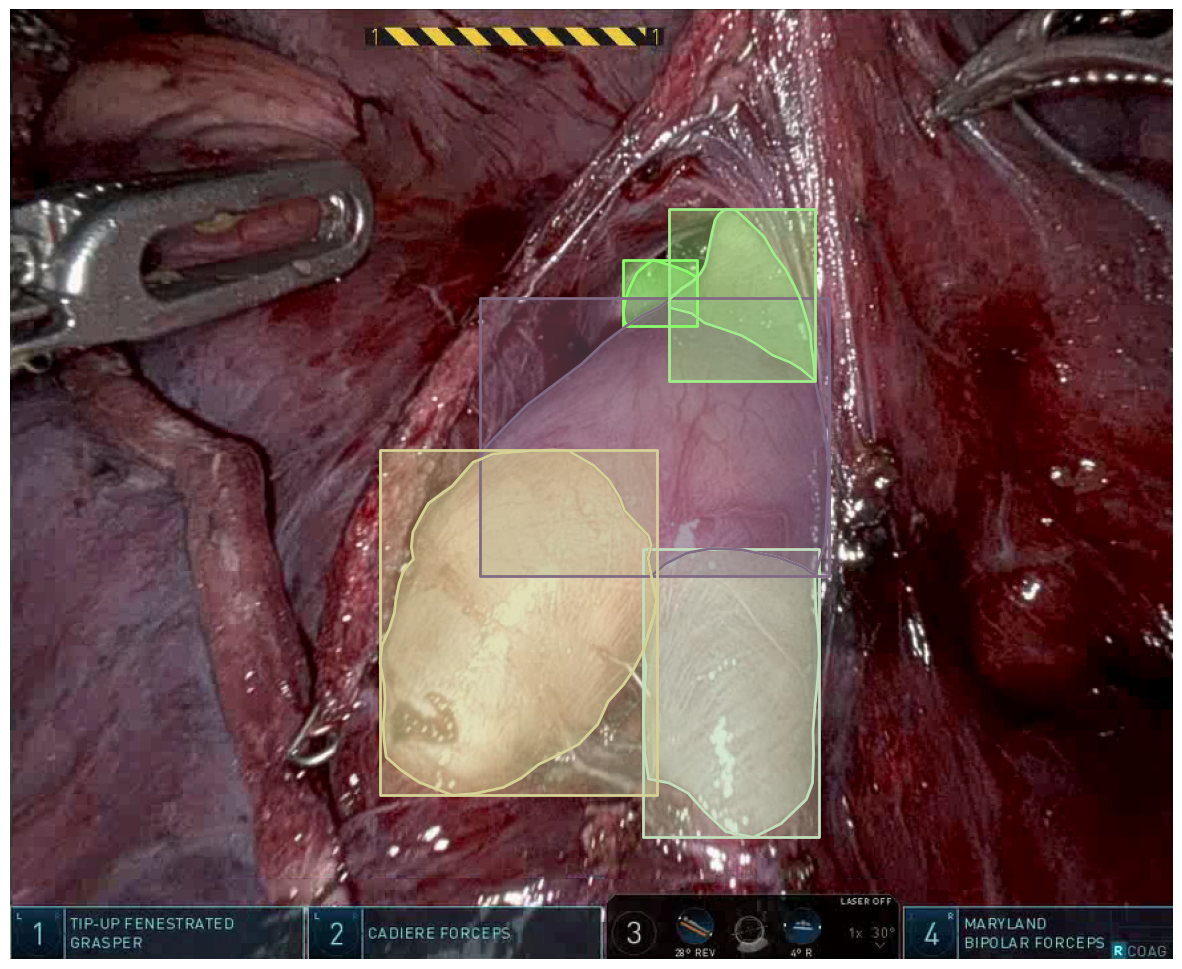

In [12]:
plt.figure(figsize=(15,15))

all_patients = "./JSONS/AllPatients-p1p2.json"

coco = COCO(all_patients)
img_dir = "./allvideo_frames"

image_id = 81
img = coco.imgs[image_id]

image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns, draw_bbox=True)
plt.axis('off')
plt.show()

## Converting Images to Video

In [45]:
patient1 = "./JSONS/p1.json"
coco = COCO(patient1)
img_dir = "./allvideo_frames"

image_id = 1
img = coco.imgs[image_id]

image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))

size1,size2,_ = image.shape
print(size1,size2)
out =   cv2.VideoWriter('patient1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 1, (size2, size1), True)
# Sorting the frames according to frame number eg: p3_frame_000530..PNG
for image_id in range(1, len(coco.imgs)+1):
    img = coco.imgs[image_id]
    image = cv2.imread(os.path.join(img_dir, img['file_name']))
    out.write(image)
out.release()

715 894


## Creating Masks Images

In [ ]:
for json_path in os.listdir("./JSONS"):
    # Take JSONS of Each Patient only
    if not json_path.startswith('p'):
        continue

    coco = COCO("./JSONS/"+json_path)
    img_dir = "./allvideo_frames"
    cat_ids = coco.getCatIds()

    mask_dir = "./allvideo_masks/"

    for idx, img_data in coco.imgs.items():

        anns_ids = coco.getAnnIds(imgIds=img_data['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)

        truth_mask = coco.annToMask(anns[0])
        for i in range(1,len(anns)):
            truth_mask = np.maximum(truth_mask,coco.annToMask(anns[i])*1)

        mask_img = Image.fromarray(truth_mask)
        # Save the img as initial_mask.png
        try:
            mask_img.save(mask_dir + img_data['file_name'])
        except FileNotFoundError:
            os.makedirs(mask_dir+img_data['file_name'].split('/')[0], exist_ok=False)
            mask_img.save(mask_dir + img_data['file_name'])

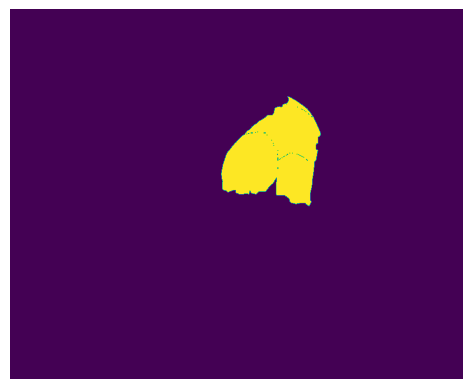

In [16]:
plt.imshow(Image.open('allvideo_masks/p3_530_559/frame_000550.PNG'))
plt.axis('off')
plt.show()

# Creating Videos of Patients with Annotations

In [13]:
def overlay_mask(image, annotations, cls2color):
    for ann in annotations:
        mask = coco.annToMask(ann)
        # Making the mask 3 channel
        mask = np.tile(mask[..., np.newaxis], (1,1,3))
        # Adding Color as per Category Id
        color = cls2color[ann['category_id']]
        mask = np.where(mask == (1,1,1), color, 0).astype('uint8')
        image = cv2.addWeighted(image, 1.0, mask, 0.5, 0)
    
    return image

CLS2COLOR = {
    1: 	(0,153,76)
}

for json_path in os.listdir("./JSONS"):
    # Take JSONS of Each Patient only
    if not json_path.startswith('p'):
        continue
    print(json_path)
    coco = COCO("./JSONS/"+json_path)
    img_dir = "./allvideo_frames"
    cat_ids = coco.getCatIds()

    frames = {}

    for idx, img_data in tqdm(coco.imgs.items()):
        
        frame = io.imread(img_dir + '/' + img_data['file_name'])
        anns_ids = coco.getAnnIds(imgIds=img_data['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)

        frame = overlay_mask(frame, anns, CLS2COLOR)
        frames[img_data['file_name']] = frame
    
    size1,size2,_ = frame.shape
    out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 1, (size2, size1), True)
    # Sorting the frames according to frame number eg: p3_frame_000530..PNG
    for _, i in sorted(frames.items(), key=lambda x: x[0]):
        out_img = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        out.write(out_img)
    out.release()

    # Convert MPV4 codec to libx264 codec
    input_file = 'output.mp4'
    output_file = f"./gt_videos/{json_path.split('.')[0]}.mp4"
    clip = VideoFileClip(input_file)
    clip.write_videofile(output_file, codec='libx264')


p1.json
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


100%|██████████| 996/996 [01:26<00:00, 11.46it/s]


Moviepy - Building video ./gt_videos/p1.mp4.
Moviepy - Writing video ./gt_videos/p1.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p1.mp4
p20.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 275/275 [00:21<00:00, 12.93it/s]


Moviepy - Building video ./gt_videos/p20.mp4.
Moviepy - Writing video ./gt_videos/p20.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p20.mp4
p7.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 293/293 [00:58<00:00,  5.02it/s]


Moviepy - Building video ./gt_videos/p7.mp4.
Moviepy - Writing video ./gt_videos/p7.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p7.mp4
p11.json
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 293/293 [00:22<00:00, 13.17it/s]


Moviepy - Building video ./gt_videos/p11.mp4.
Moviepy - Writing video ./gt_videos/p11.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p11.mp4
p10.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 159/159 [00:16<00:00,  9.48it/s]


Moviepy - Building video ./gt_videos/p10.mp4.
Moviepy - Writing video ./gt_videos/p10.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p10.mp4
p6.json
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 301/301 [00:08<00:00, 35.87it/s]


Moviepy - Building video ./gt_videos/p6.mp4.
Moviepy - Writing video ./gt_videos/p6.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p6.mp4
p13.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 301/301 [00:30<00:00,  9.98it/s]


Moviepy - Building video ./gt_videos/p13.mp4.
Moviepy - Writing video ./gt_videos/p13.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p13.mp4
p5.json
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 301/301 [00:08<00:00, 35.03it/s]


Moviepy - Building video ./gt_videos/p5.mp4.
Moviepy - Writing video ./gt_videos/p5.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p5.mp4
p4.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 301/301 [00:42<00:00,  7.12it/s]


Moviepy - Building video ./gt_videos/p4.mp4.
Moviepy - Writing video ./gt_videos/p4.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p4.mp4
p3.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 261/261 [00:23<00:00, 11.21it/s]


Moviepy - Building video ./gt_videos/p3.mp4.
Moviepy - Writing video ./gt_videos/p3.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p3.mp4
p2.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 301/301 [00:29<00:00, 10.31it/s]


Moviepy - Building video ./gt_videos/p2.mp4.
Moviepy - Writing video ./gt_videos/p2.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p2.mp4
p14.json
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


100%|██████████| 301/301 [00:23<00:00, 12.57it/s]


Moviepy - Building video ./gt_videos/p14.mp4.
Moviepy - Writing video ./gt_videos/p14.mp4



Moviepy - Done !
Moviepy - video ready ./gt_videos/p14.mp4


### Counting Frames in each Pateint

In [ ]:
patient_frames = 0
patient_ann = 0

p2frames = {}
p2ann = {}

for json_path in os.listdir("./JSONS"):
    # Take JSONS of Each Patient only
    if not json_path.startswith('p'):
        continue
    with open("./JSONS/"+json_path, 'r') as f:
        json_data = json.load(f)
    patient_frames += len(json_data['images'])
    patient_ann += len(json_data['annotations'])

    p2frames[json_path] = len(json_data['images'])
    p2ann[json_path] = len(json_data['annotations'])

print(patient_frames)
print(patient_ann)
print(p2frames)
print(p2ann)

### Calculate Small, Medium and Large Segmentation Objects

In [ ]:
import json
import os

def calculate_segmentation_size(segmentation):
    # Calculate the area of a segmentation
    # Segmentation is represented as a list of polygons in COCO format
    area = 0
    for polygon in segmentation:
        area += polygon['area']
    return area

def count_instances(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    small_count = 0
    medium_count = 0
    large_count = 0

    annotations = data['annotations']
    for annotation in annotations:
        # segmentation = annotation['segmentation']
        area = annotation['area']

        if area < 32 * 32:
            small_count += 1
        elif area < 96 * 96:
            medium_count += 1
        else:
            large_count += 1

    return small_count, medium_count, large_count

# Provide the path to the JSON file
small_total, medium_total, large_total = 0,0,0
for json_file_path in os.listdir("JSONS"):
    print(json_file_path)
    small_count, medium_count, large_count = count_instances("JSONS/"+json_file_path)

    print("Small instances:", small_count)
    print("Medium instances:", medium_count)
    print("Large instances:", large_count)
    print('*'*50)
    small_total += small_count
    medium_total += medium_count
    large_total += large_count

print("Small Total:", small_total)
print("Medium Total:", medium_total)
print("Large Total:", large_total)